# ILIAS FAEK 573067
# ARFANI ABDELSAMAD 501891
# Richter’s Predictor: Modeling Earthquake Damage
## Group name on the competition : Arfani-Faek
## ULB-INFO-F-422 - Richter-s-predictor-group-15
## Video link : https://web.microsoftstream.com/video/e04b4262-92e9-4945-88d4-97a1cf9f128f



In [ ]:
# Import needed librairies
libraries <- c("data.table","rpart","randomForest","randomForestExplainer","mltools", "e1071","keras","tensorflow","skimr","ISwR","klaR",
               "GGally","ggplot2","DescTools","dummy","corrplot","caret")

for (lib in libraries) {
  if (!require(lib, character.only = TRUE)) {
    install.packages(lib)
    library(lib, character.only = TRUE)
  }
}

In [ ]:
# Set seed for reproducibility
set.seed(3)

# Import Data

In [ ]:
# Load data
train_labels <- read.csv("train_labels.csv",  stringsAsFactors=T,)
train_values <- read.csv("train_values.csv",  stringsAsFactors=T)
test_values <- read.csv("test_values.csv",  stringsAsFactors=T)
submission <- read.csv("submission_format.csv")

# Data exploration

In [ ]:
#Dimensions of data
dim(train_values)
dim(train_labels)

[1] 260601     39

[1] 260601      2

In [ ]:
train_values[1:3,]
train_labels[1:3,]
test_values[1:3,]

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,⋯,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,802906,6,487,12198,2,30,6,5,t,r,⋯,0,0,0,0,0,0,0,0,0,0
2,28830,8,900,2812,2,10,8,7,o,r,⋯,0,0,0,0,0,0,0,0,0,0
3,94947,21,363,8973,2,10,5,5,t,r,⋯,0,0,0,0,0,0,0,0,0,0


,building_id,damage_grade
,<int>,<int>
1,802906,3
2,28830,2
3,94947,3


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,⋯,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,300051,17,596,11307,3,20,7,6,t,r,⋯,0,0,0,0,0,0,0,0,0,0
2,99355,6,141,11987,2,25,13,5,t,r,⋯,1,0,0,0,0,0,0,0,0,0
3,890251,22,19,10044,2,5,4,5,t,r,⋯,0,0,0,0,0,0,0,0,0,0


## Check for number of missing values

In [ ]:
sum(is.na(train_values))

[1] 0

In [ ]:
sum(is.na(train_labels))

[1] 0

In [ ]:
sum(is.na(test_values))

[1] 0

In [ ]:
train_data <- merge(x=train_values, y=train_labels, by='building_id')
train_data[1:3,]

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,⋯,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,4,30,266,1224,1,25,5,2,t,r,⋯,0,0,0,0,0,0,0,0,0,2
2,8,17,409,12182,2,0,13,7,t,r,⋯,0,0,0,0,0,0,0,0,0,3
3,12,17,716,7056,2,5,12,6,o,r,⋯,0,0,0,0,0,0,0,0,0,3


## Duplicated building_id

In [ ]:
duplicates <- train_data[,'building_id']
duplicates <- duplicated(duplicates)
sum(duplicates == TRUE)

[1] 0

## Categorical variables

In [ ]:
factor_variables <- which(sapply(train_values[1,],class)=="factor")
train_data[1:3,factor_variables]

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,t,r,n,f,j,s,d,v
2,t,r,n,f,q,s,d,v
3,o,r,q,f,q,s,d,v


In [ ]:
summary(train_data)

  building_id      geo_level_1_id geo_level_2_id   geo_level_3_id 
 Min.   :      4   Min.   : 0.0   Min.   :   0.0   Min.   :    0  
 1st Qu.: 261190   1st Qu.: 7.0   1st Qu.: 350.0   1st Qu.: 3073  
 Median : 525757   Median :12.0   Median : 702.0   Median : 6270  
 Mean   : 525676   Mean   :13.9   Mean   : 701.1   Mean   : 6258  
 3rd Qu.: 789762   3rd Qu.:21.0   3rd Qu.:1050.0   3rd Qu.: 9412  
 Max.   :1052934   Max.   :30.0   Max.   :1427.0   Max.   :12567  
                                                                  
 count_floors_pre_eq      age         area_percentage   height_percentage
 Min.   :1.00        Min.   :  0.00   Min.   :  1.000   Min.   : 2.000   
 1st Qu.:2.00        1st Qu.: 10.00   1st Qu.:  5.000   1st Qu.: 4.000   
 Median :2.00        Median : 15.00   Median :  7.000   Median : 5.000   
 Mean   :2.13        Mean   : 26.54   Mean   :  8.018   Mean   : 5.434   
 3rd Qu.:2.00        3rd Qu.: 30.00   3rd Qu.:  9.000   3rd Qu.: 6.000   
 Max.   :9.00       

In [ ]:
summary(test_values)

  building_id      geo_level_1_id  geo_level_2_id   geo_level_3_id 
 Min.   :      7   Min.   : 0.00   Min.   :   0.0   Min.   :    0  
 1st Qu.: 264422   1st Qu.: 7.00   1st Qu.: 350.0   1st Qu.: 3073  
 Median : 526984   Median :12.00   Median : 709.0   Median : 6276  
 Mean   : 526628   Mean   :13.89   Mean   : 704.1   Mean   : 6262  
 3rd Qu.: 789084   3rd Qu.:21.00   3rd Qu.:1054.0   3rd Qu.: 9416  
 Max.   :1052923   Max.   :30.00   Max.   :1427.0   Max.   :12567  
                                                                   
 count_floors_pre_eq      age         area_percentage  height_percentage
 Min.   :1.000       Min.   :  0.00   Min.   : 1.000   Min.   : 2.000   
 1st Qu.:2.000       1st Qu.: 10.00   1st Qu.: 5.000   1st Qu.: 4.000   
 Median :2.000       Median : 15.00   Median : 7.000   Median : 5.000   
 Mean   :2.133       Mean   : 26.55   Mean   : 8.014   Mean   : 5.436   
 3rd Qu.:2.000       3rd Qu.: 30.00   3rd Qu.: 9.000   3rd Qu.: 6.000   
 Max.   :8.000    

## Damage grade distribution 

Proportion of each label in % : 



        1         2         3 
 9.640792 56.891186 33.468022 

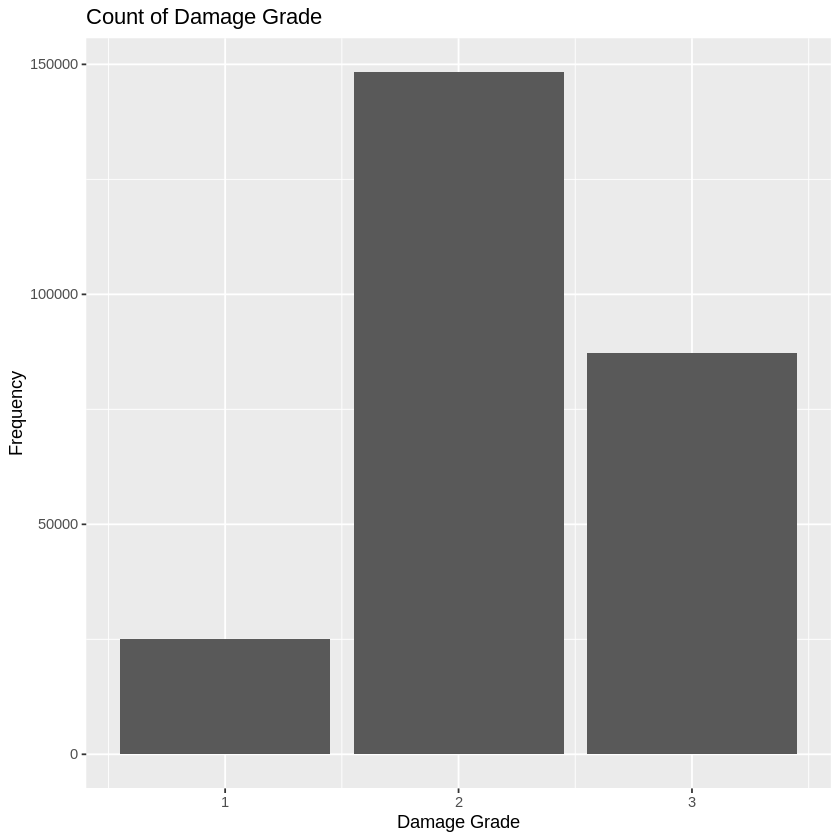

In [ ]:
ggplot(train_labels, aes(x = damage_grade)) +
  geom_bar() +
  xlab("Damage Grade") +
  ylab("Frequency") +
  ggtitle("Count of Damage Grade")

# Compute the frequency table for the damage_grade variable
freq_table <- table(train_labels$damage_grade)
prop_table <- prop.table(freq_table)
percentage_table <- prop_table * 100
cat("Proportion of each label in % : \n")
percentage_table

From the previous graph, it is easy to see that our data set is highly imbalanced.
Of the above, approximately 56.89% of the damage to buildings has an average severity level, followed by high at 33.47% and low at 9.64%. This means that most of the construction in Nepal has a meduim and high-level damage after the earthquake, with only a few buildings having a low level of damage.

## Relationship between input features vs damage_grade

Let's look a the distribution of some features values according to the damage grade. We choosed to look at these specific features because we have noticed that they appears very often in the importance ranking features that we made with the PCA algorithm and other techniques.

In [ ]:
my.theme <- theme_bw() + theme(                              
  axis.title.x = element_text(face="bold", color="black", size=9),
  axis.title.y = element_text(face="bold", color="black", size=9),
  axis.text = element_text(size=12)) + theme(axis.text.x = element_text(angle = 90,
                                   vjust = 0.5,
                                   hjust = 0.5))

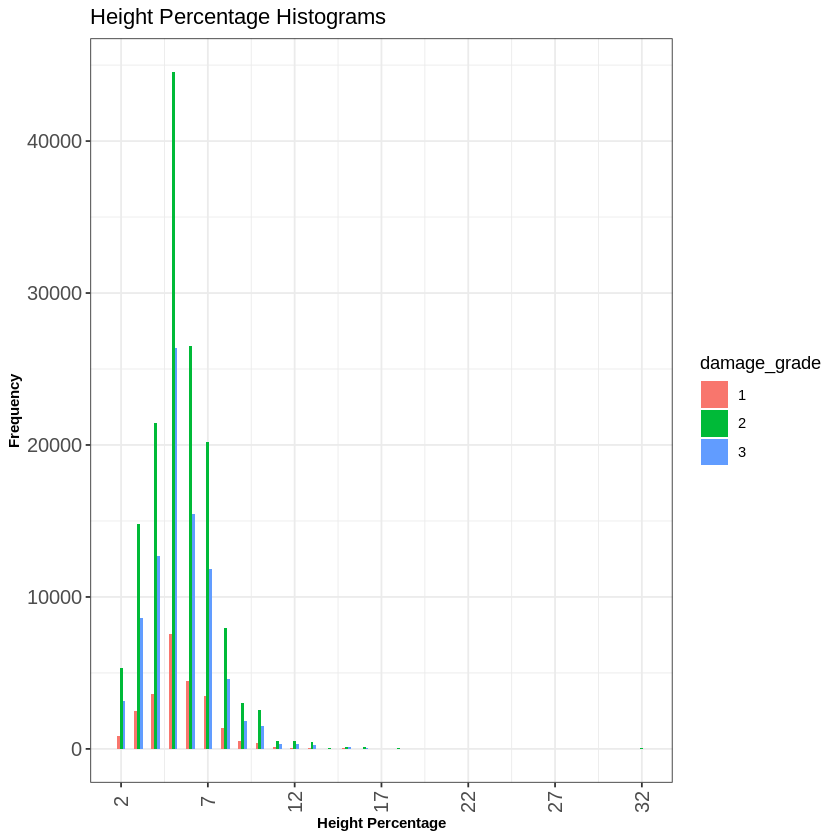

In [ ]:
ggplot(data = train_data, aes(x = height_percentage)) + my.theme +
  geom_bar(aes(fill = factor(train_labels$damage_grade)), position = "dodge",width = 0.5) +
  scale_fill_discrete(name = "damage_grade", labels = c("1", "2", "3")) +
  xlab("Height Percentage") +
  ylab("Frequency") +
  ggtitle("Height Percentage Histograms")+
scale_x_continuous(breaks = seq(min(train_data$height_percentage), max(train_data$height_percentage), by = 5))

We can see that most of the values for these for building's height are low and there is only few (extreme) values that goes up to 32.
We also see as previously that the most appearing damage_grade is "medium" mostly caused by buildings of heights around 4.

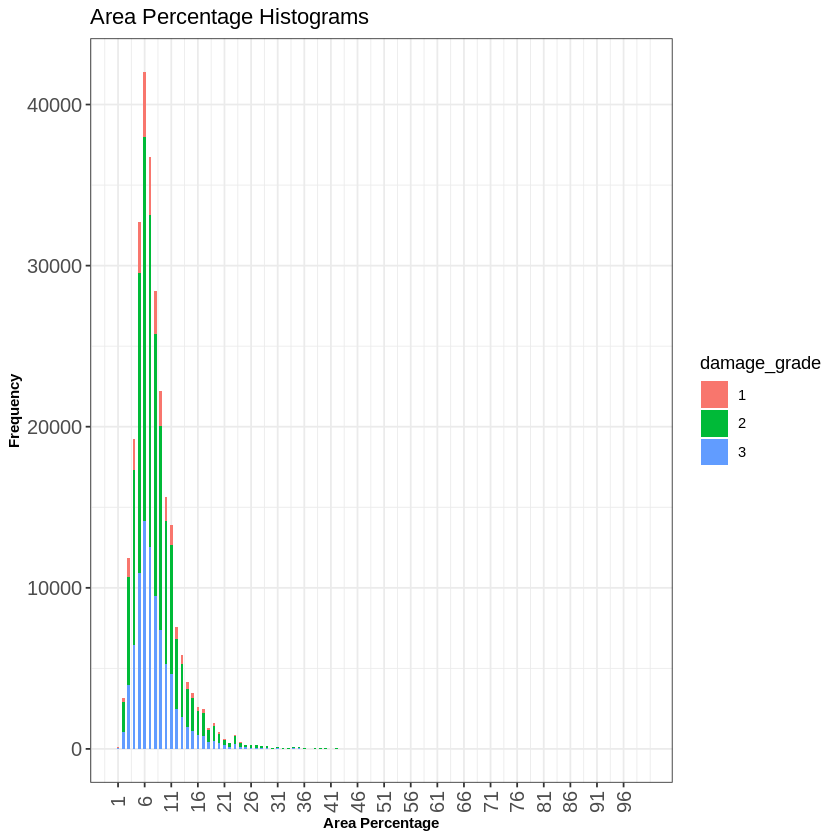

In [ ]:
ggplot(data = train_data, aes(x = area_percentage)) + my.theme +
  geom_bar(aes(fill = factor(train_labels$damage_grade)),width = 0.5) +
  scale_fill_discrete(name = "damage_grade", labels = c("1", "2", "3")) +
  xlab("Area Percentage") +
  ylab("Frequency") +
  ggtitle("Area Percentage Histograms")+
scale_x_continuous(breaks = seq(min(train_data$area_percentage), max(train_data$area_percentage), by = 5))

Same remark for this plot, the range of most values is between 1 and 20. The most frequent values are also the lowest one so this puts us to the idea that we could do without outliers since they are not the most represented in the distribution.

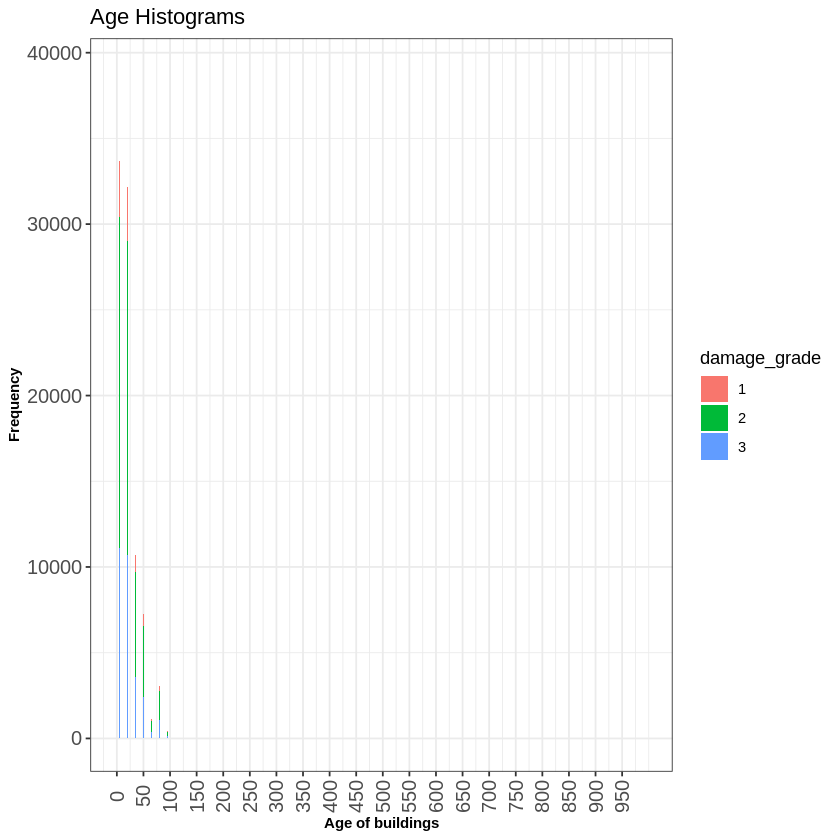

In [ ]:
par(mfrow=c(1,2))
ggplot(data = train_data, aes(x = age)) + my.theme +
  geom_bar(aes(fill = factor(train_labels$damage_grade)),width = 0.5) +
  scale_fill_discrete(name = "damage_grade", labels = c("1", "2", "3")) +
  xlab("Age of buildings") +
  ylab("Frequency") +
  ggtitle("Age Histograms")+
scale_x_continuous(breaks = seq(min(train_data$age), max(train_data$age), by = 50))

We notice that most of values are represented between 25 and 100, however it appears that buildings in Nepal might be very old since the x range goes up to 950. Clearly, we see that we need to regularise our data so our model model doesn't focus on non-common data.

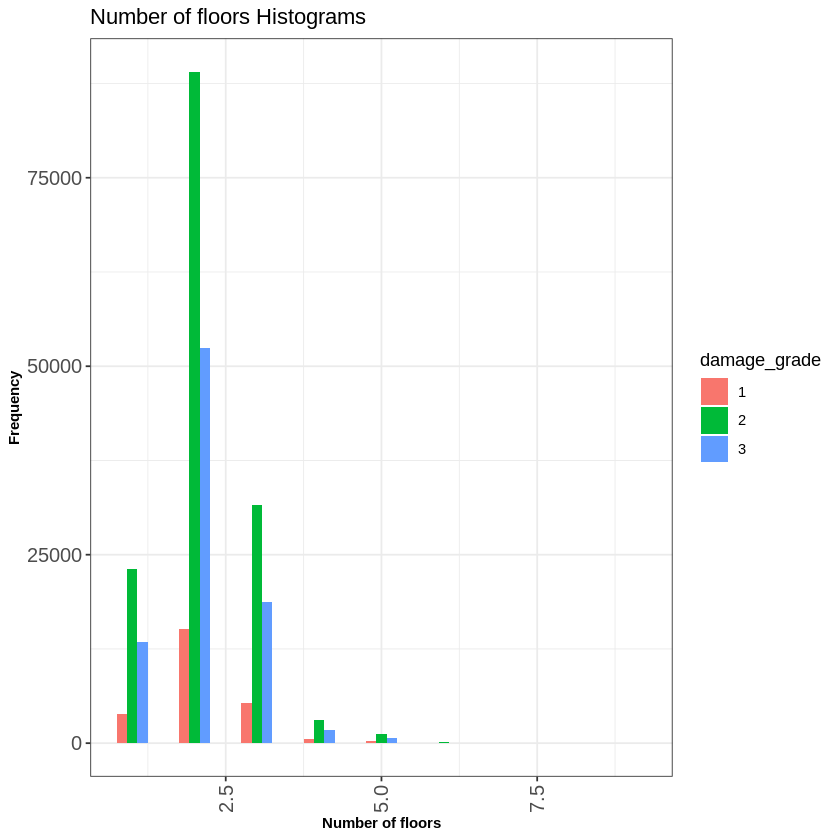

In [ ]:
ggplot(data = train_data, aes(x = count_floors_pre_eq)) + my.theme +
  geom_bar(aes(fill = factor(train_labels$damage_grade)), position = "dodge",width = 0.5) +
  scale_fill_discrete(name = "damage_grade", labels = c("1", "2", "3")) +
  xlab("Number of floors") +
  ylab("Frequency") +
  ggtitle("Number of floors Histograms")

The buildings with 2 floors suffer the greatest damage. Once again there are not to much high values in the dataset.

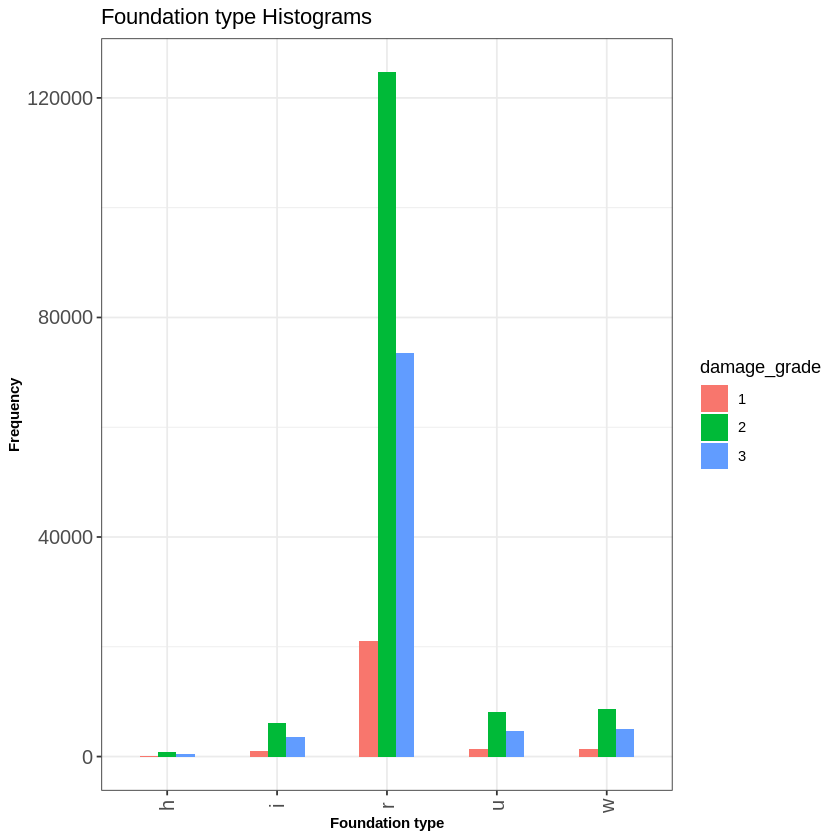

In [ ]:
ggplot(data = train_data, aes(x = foundation_type)) + my.theme +
  geom_bar(aes(fill = factor(train_labels$damage_grade)), position = "dodge",width = 0.5) +
  scale_fill_discrete(name = "damage_grade", labels = c("1", "2", "3")) +
  xlab("Foundation type") +
  ylab("Frequency") +
  ggtitle("Foundation type Histograms")

We see that commonly most of buildings have the same foundation type "r" that may be responsible of the high damages on buildings.

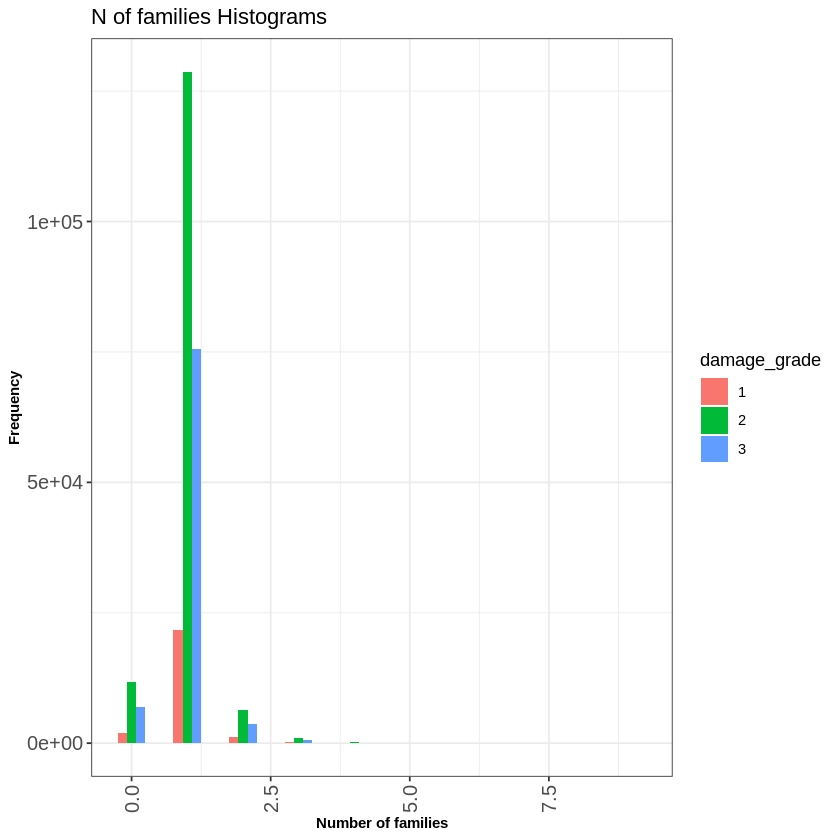

In [ ]:
ggplot(data = train_data, aes(x = count_families)) + my.theme +
  geom_bar(aes(fill = factor(train_labels$damage_grade)), position = "dodge",width = 0.5) +
  scale_fill_discrete(name = "damage_grade", labels = c("1", "2", "3")) +
  xlab("Number of families") +
  ylab("Frequency") +
  ggtitle("N of families Histograms")

The majority of the buildings had a single family. When we compare this plot with the number of floors, we can see that the distribution look almost the same with values going up to 9. It gives us the intuition that somehow the number of family in a building is correlated with the number of floors. We will study correlations between variables more after.

## Remove Outliers - Winsorization

The following code is used to perform winsorization. Firstly, we identify values in the given column that fall outside a defined bounds as outliers, and estimate the proportion of outliers in the data. Once it is done, we replace the extreme values of a feature by the value of the bounding quartiles we defined. This technique is used to reduce the impact of outliers on the model.

In [ ]:
computeOutlierProportion<-function(feature,data){
    feature_vals <- data[[feature]]
    # Calculate interquartile range (IQR)
    iqr <- IQR(feature_vals)
    # Calculate lower and upper bounds for outliers
    lower_bound <- quantile(feature_vals, 0.25) - 1.5 * iqr
    upper_bound <- quantile(feature_vals, 0.75) + 1.5 * iqr
    # Identify outliers
    outliers <- feature_vals[feature_vals < lower_bound | feature_vals > upper_bound]
    # Estimate proportion of outliers
    outlier_proportion <- length(outliers) / length(feature_vals)
    return (round(outlier_proportion,digits = 2))
}

In [ ]:
#Winsorization
winsorize<-function(feature_names,data){
    for(name in feature_names){
    par(mfrow=c(1,2))
    cp<-computeOutlierProportion(name,data)
    percentile <- 1-cp
    feature_col<-data[[name]]
    # Before winsorization
    boxplot(feature_col, main = "Before Winsorization", xlab = name)
    # Winsorization
    winsorized_data <- Winsorize(feature_col, probs = c(0, percentile))
    # After winsorization
    boxplot(winsorized_data,main = "After Winsorization", xlab = name)
    # Replace data in dataset
    data[[name]] <- winsorized_data
}
    return (data)
}

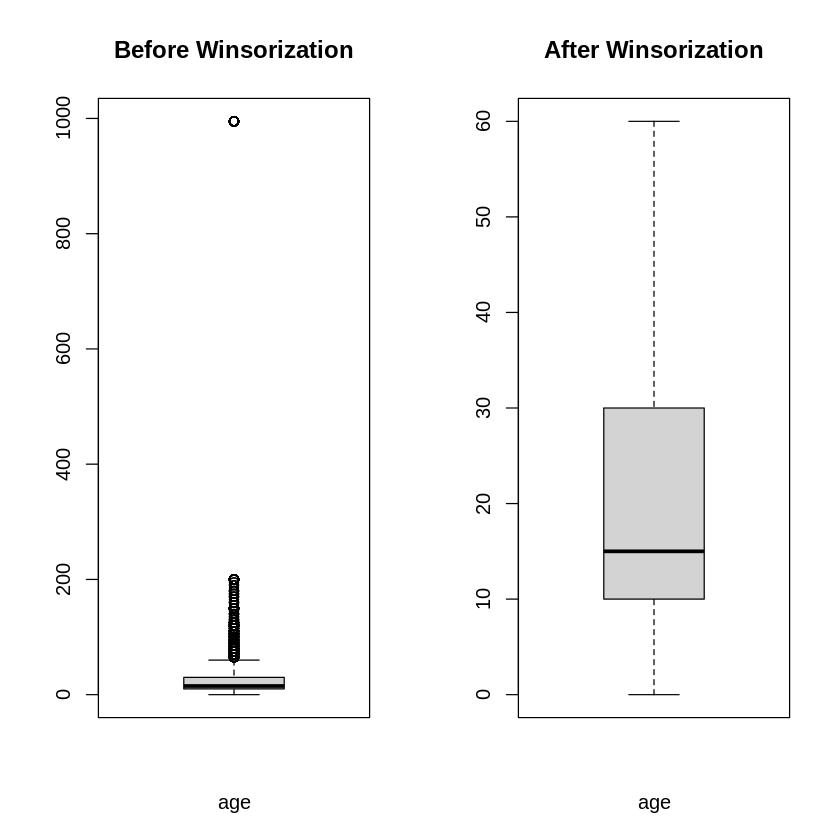

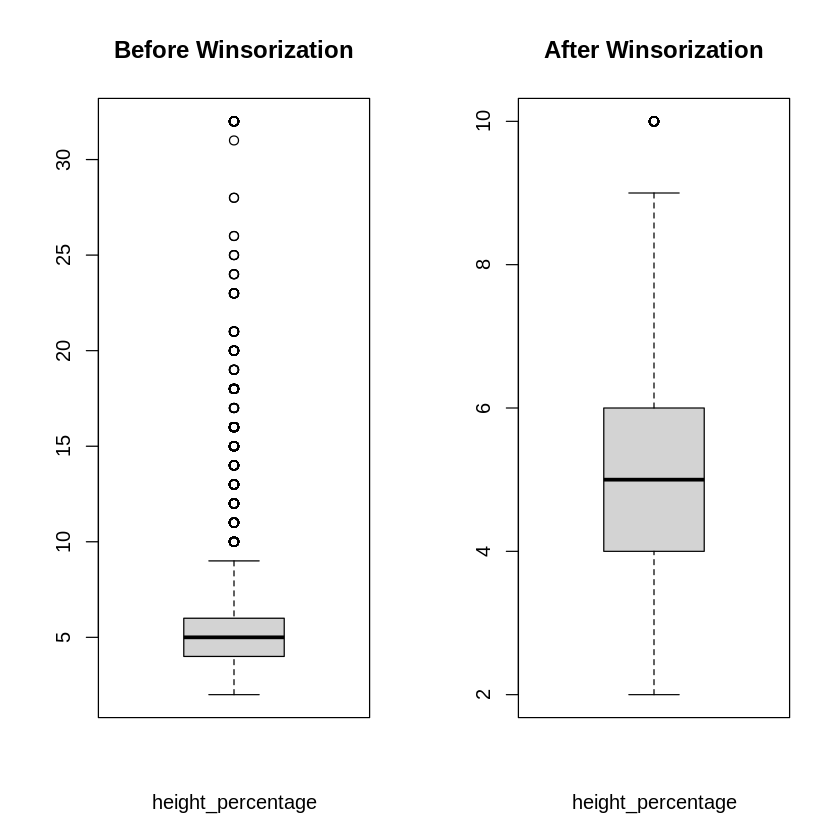

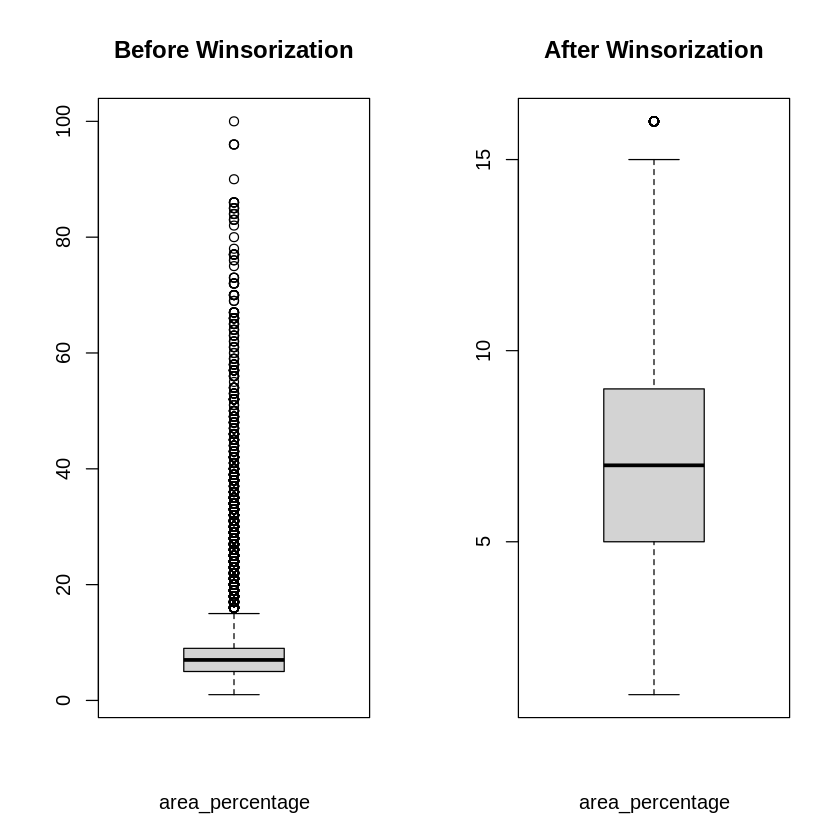

In [ ]:
train_data<-winsorize(c("age","height_percentage","area_percentage"),train_data)

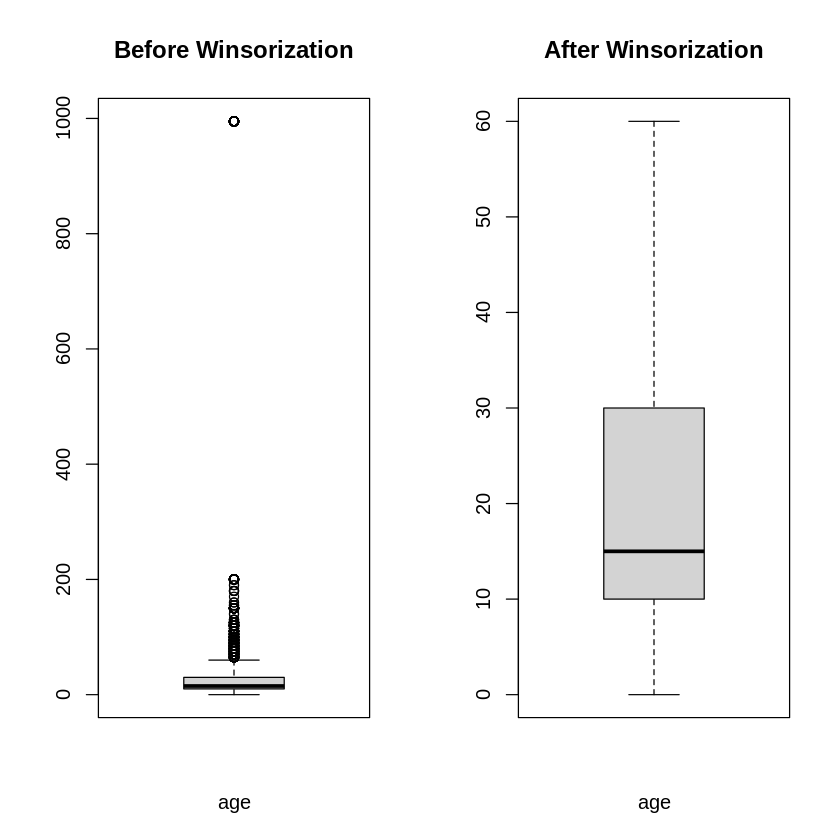

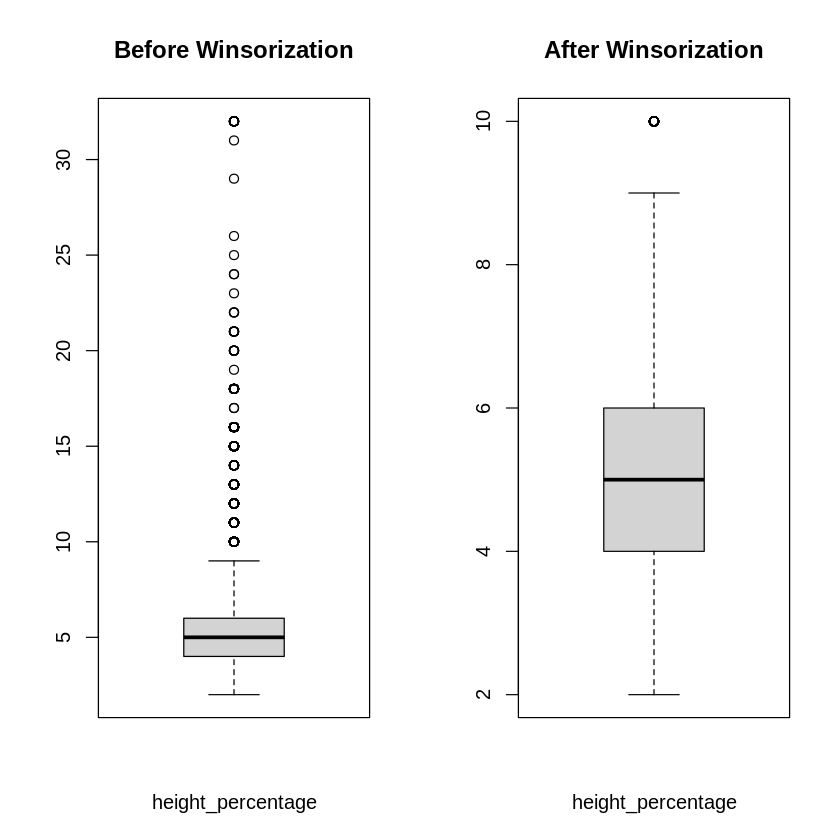

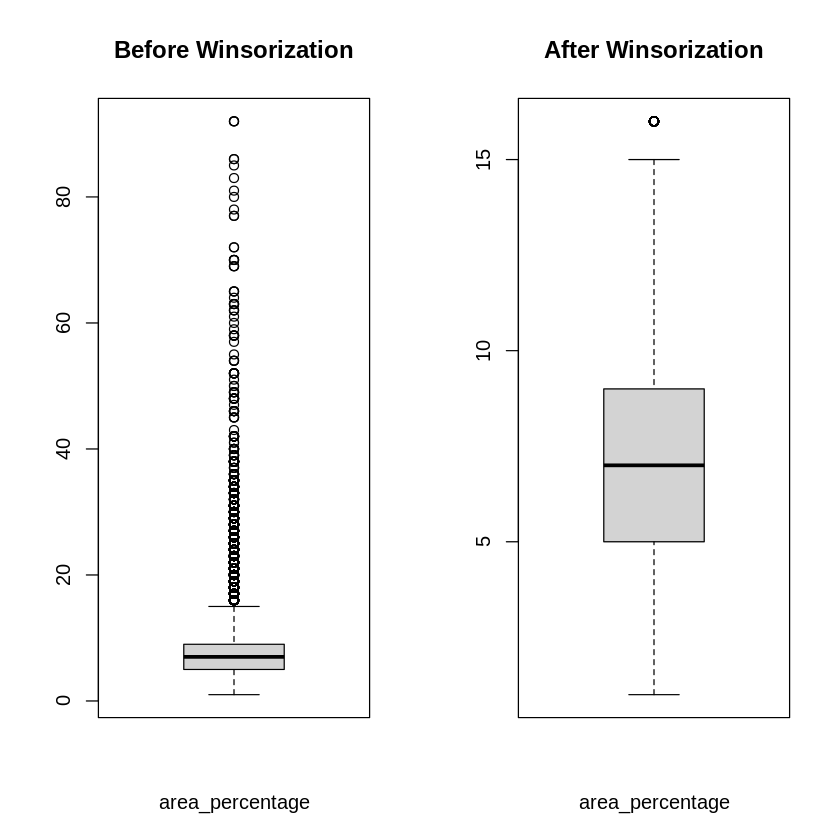

In [ ]:
test_values<-winsorize(c("age","height_percentage","area_percentage"),test_values)

We perform winzorisation over the train and test values for the age, height_percentage and are_percentage columns. We can see that after winsorization, only the most representative values are retained

## Correlation

Strongly correlated features give the same types of information and therefore add unnecessary features. Therefore, we can remove them to decrease the training time our models and avoid overfitting.

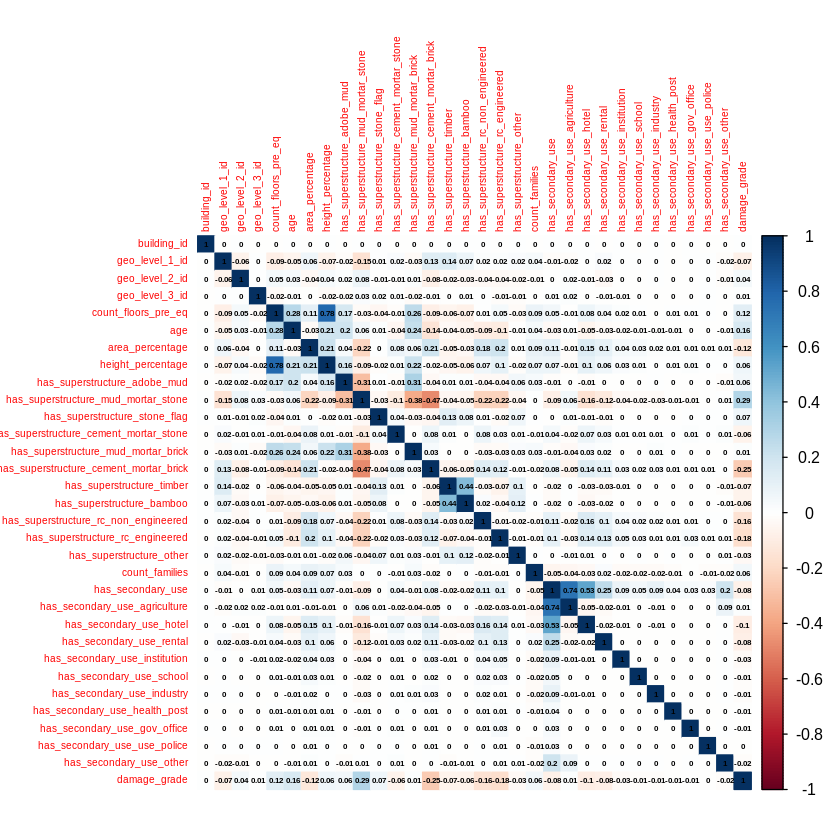

In [ ]:
numeric_df <- train_data[, sapply(train_data, is.numeric)]
correlations <- cor(numeric_df)
corrplot(correlations, method = "color", addCoef.col = "black", number.cex = 0.4, tl.cex = 0.5,number.digits = 2)

We notice that features 'count_floors_pre_eq' and 'height_percentage' are strongly correlated (lineary) to 77%
We consider that features are very correlated when there are bigger than 0.5.
There are also these pairs : 'has_secondary_use_agriculture' vs 'has_secondary_use' and 'has_secondary_use' vs 'has_secondary_use_hotel' that are higly correlated.
To choose the useless features to delete, we check the correlation of each pair with damage_grade and remove the one with the lowest.
After analysis, we detected that these features should be removed : 'height_percentage','has_secondary_use_agriculture','has_secondary_use'

In [ ]:
n_corr <-dim(correlations)[1]
n_corr

[1] 32

In [ ]:
# Delete all features with correlation > 0.5 and keep only the best one
to_delete = c()
for (i in 2:(n_corr-1)) {
    for (j in i:(n_corr-1)) {
        if (correlations[i,j] > 0.5 &  i!=j) {
            if (abs(correlations[i,n_corr]) < abs(correlations[j,n_corr])) {
                to_delete <- c(to_delete, i)
            } else {
                to_delete <- c(to_delete, j)
            }
        }
    }
}

to_delete <- to_delete[!duplicated(to_delete)]

In [ ]:
correlated_features<-rownames(correlations[to_delete,])
correlated_features

[1] "height_percentage"             "has_secondary_use_agriculture"
[3] "has_secondary_use"

In addition to removing correlated variables, we also remove 'building_id' as it useless for the model prediction.

In [ ]:
train_data<-train_data[,setdiff(colnames(train_data),c('building_id','height_percentage','has_secondary_use_agriculture','has_secondary_use'))]
train_data[1:3,]

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,⋯,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,30,266,1224,1,25,5,t,r,n,f,⋯,0,0,0,0,0,0,0,0,0,2
2,17,409,12182,2,0,13,t,r,n,f,⋯,0,0,0,0,0,0,0,0,0,3
3,17,716,7056,2,5,12,o,r,q,f,⋯,0,0,0,0,0,0,0,0,0,3


In [ ]:
test_values<-test_values[,setdiff(colnames(test_values),c('building_id','height_percentage','has_secondary_use_agriculture','has_secondary_use'))]
test_values[1:3,]

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,⋯,count_families,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,17,596,11307,3,20,7,t,r,n,f,⋯,1,0,0,0,0,0,0,0,0,0
2,6,141,11987,2,25,13,t,r,n,f,⋯,1,0,0,0,0,0,0,0,0,0
3,22,19,10044,2,5,4,t,r,n,f,⋯,1,0,0,0,0,0,0,0,0,0


## One hot encoding

In [ ]:
train_data <- one_hot(as.data.table(train_data))
test_values <- one_hot(as.data.table(test_values))
train_data[1:2,]
test_values[1:2,]

geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,⋯,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
30,266,1224,1,25,5,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,2
17,409,12182,2,0,13,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,3


geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,⋯,count_families,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
17,596,11307,3,20,7,0,0,1,0,⋯,1,0,0,0,0,0,0,0,0,0
6,141,11987,2,25,13,0,0,1,0,⋯,1,0,0,0,0,0,0,0,0,0


As we have categorical features, we have to convert factor into numerical. For this we use the one-hot encoding.
It simply create new column for each possible feature of the factor column with 0 or 1 indicating if the row has that type of value or not. But it greatly increases the number of columns which is a disavantage for computation speed. 
The benefit of doing that is that our models could take into account the specific information given by categorical variables instead of deleting these data.

In [ ]:
#transform from data.table (caused by the one-hot func) into a dataframe
train_data<-data.frame(train_data)
test_values<-data.frame(test_values)

In [ ]:
smp_size  <- floor(0.75 * nrow(train_data))
train_idx <- sample(seq_len(nrow(train_data)), size = smp_size)
train_data <- train_data[train_idx,]
eval_data  <- train_data[-train_idx,]
dim(train_data)
dim(eval_data)

[1] 195450     66

[1] 48974    66

We split the dataset into training and validation data. The training data is used to build models, while the validation data is for validating the performances.
The reason of doing that is to prevent overfitting and might help to deal with the intial unbalanced dataset we have. That allows to generalize performance on new data.

In [ ]:
X <- train_data[,setdiff(colnames(train_data),c("damage_grade"))]
X_test<-eval_data[,setdiff(colnames(train_data),c("damage_grade"))]

Y <- train_data[,"damage_grade"]
Y_test <- eval_data[,"damage_grade"]
head(Y)
head(X)

N <- nrow(X)    #Number of examples
n <- ncol(X)    #Number of input variables without building_id
CV_folds    <- 10
size_CV  <- floor(N/CV_folds)

[1] 2 2 3 2 3 2

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,⋯,count_families,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
52922,8,463,10502,2,15,7,0,0,1,0,⋯,1,0,0,0,0,0,0,0,0,0
218087,25,868,362,2,25,8,0,0,1,0,⋯,1,0,0,0,0,0,0,0,0,0
236218,21,935,1956,2,0,6,0,0,1,0,⋯,1,0,0,0,0,0,0,0,0,0
215915,21,313,6134,2,5,3,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
172424,10,804,268,2,25,4,0,0,1,0,⋯,1,0,0,0,0,0,0,0,0,0
229706,20,385,10589,2,5,9,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


# Feature selection
## PCA

PCA (Principal Component Analysis) is a procedure that transforms a large set of variables into a smaller set that help us to identify most important features. It reduces the dimensionality, preserves most of the information and variance in the original dataset. 
After applying that method, we will reduce the number of features that our model will train with, to the essential ones.

In [ ]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

# Compute PCA on the full input dataset X and return the dataset transformed in the space of principal components
X_pca<-data.frame(prcomp(X,retx=T)$x)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_pca[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_pca[idx_tr,]
    Y_tr<-Y[idx_tr]         
     
    for (nb_components in 1:n) {
        # Create a dataset including only the first nb_components principal components
        DS<-cbind(X_tr[,1:nb_components,drop=F],damage_grade=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(damage_grade~.,DS)
        
        # Model predict
        Y_hat_ts<- predict(model,X_ts[,1:nb_components,drop=F])
        CV_err[nb_components,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

 [1] "#Features:  1  ; CV error= 0.3742  ; std dev= 0.0036" 
 [2] "#Features:  2  ; CV error= 0.3735  ; std dev= 0.0037" 
 [3] "#Features:  3  ; CV error= 0.3636  ; std dev= 0.0034" 
 [4] "#Features:  4  ; CV error= 0.3622  ; std dev= 0.0035" 
 [5] "#Features:  5  ; CV error= 0.3571  ; std dev= 0.0033" 
 [6] "#Features:  6  ; CV error= 0.3468  ; std dev= 0.0035" 
 [7] "#Features:  7  ; CV error= 0.3267  ; std dev= 0.0026" 
 [8] "#Features:  8  ; CV error= 0.3267  ; std dev= 0.0026" 
 [9] "#Features:  9  ; CV error= 0.3266  ; std dev= 0.0026" 
[10] "#Features:  10  ; CV error= 0.3222  ; std dev= 0.0024"
[11] "#Features:  11  ; CV error= 0.3209  ; std dev= 0.0023"
[12] "#Features:  12  ; CV error= 0.3105  ; std dev= 0.0022"
[13] "#Features:  13  ; CV error= 0.3102  ; std dev= 0.0022"
[14] "#Features:  14  ; CV error= 0.3094  ; std dev= 0.0022"
[15] "#Features:  15  ; CV error= 0.3072  ; std dev= 0.0022"
[16] "#Features:  16  ; CV error= 0.3071  ; std dev= 0.0021"
[17] "#Features:  17  ; 

We will take into consideration as many features as we can reduce the cross validation error for our models.
The results show that as the number of features increases, the cross-validation error decreases. However, after a certain number of features (around 10), the decrease in error becomes less significant. This suggests that using more than 10 features may not significantly improve the model’s performance. 
The second method we use to filter over most important features is the ranking of a random forest model after training with all features. During the model build, different importance measures for each features is computed

## Random forest variable importances ranking

In [ ]:
DS_train <- cbind(X[,],damage_grade=as.factor(Y))
head(DS_train)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,⋯,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
52922,8,463,10502,2,15,7,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,2
218087,25,868,362,2,25,8,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,2
236218,21,935,1956,2,0,6,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,3
215915,21,313,6134,2,5,3,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,2
172424,10,804,268,2,25,4,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,3
229706,20,385,10589,2,5,9,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2


In [ ]:
#Build the model that help us to determine the importance of variables

# --> Decomment what's follows to re-build the model 

# rf_model_6_rtree300=randomForest(damage_grade~ . , data = DS_train,importance=T,
#                         ntree=300,
#                         maxdepth = 45,
#                         minsplit = 3,
#                         minbucket = 30)

# rf_model_6_rtree300

In [ ]:
# Save the model to a file
# saveRDS(rf_model_6_rtree300, file = "./rf_rtree300_importance.rds")

# Load the saved model
rf_300_importance <- readRDS(file = "rf_rtree300_importance.rds")
rf_300_importance


Call:
 randomForest(formula = damage_grade ~ ., data = DS_train, importance = T,      ntree = 300, maxdepth = 45, minsplit = 3, minbucket = 30) 
               Type of random forest: classification
                     Number of trees: 300
No. of variables tried at each split: 8

        OOB estimate of  error rate: 28.83%
Confusion matrix:
     1     2     3 class.error
1 8091 10477   258   0.5702220
2 3477 95422 12317   0.1420119
3  278 29543 35587   0.4559228

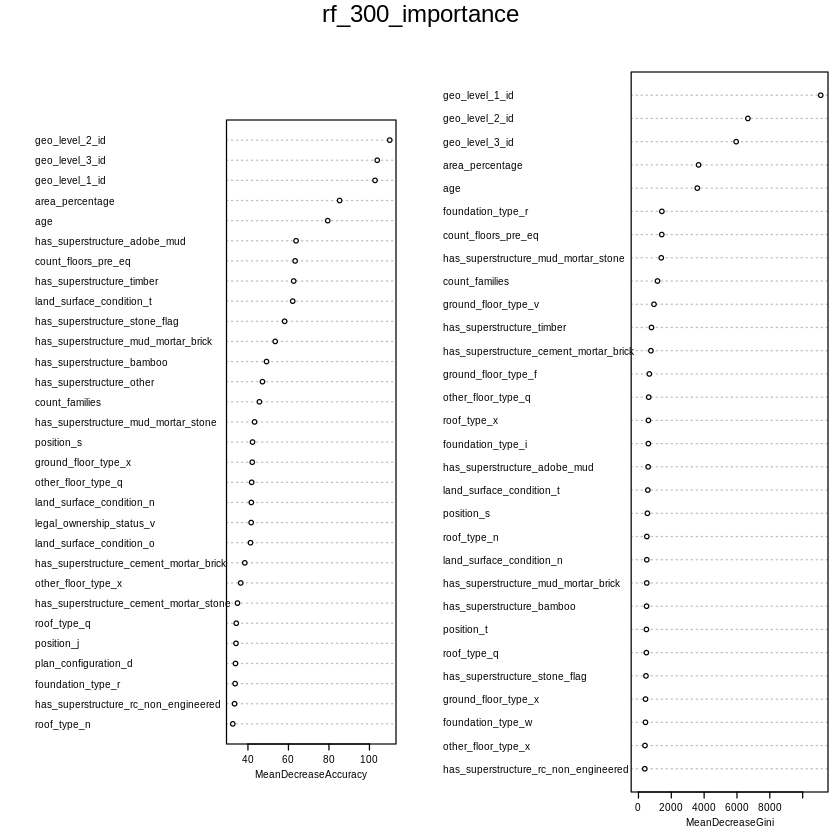

In [ ]:
varImpPlot(rf_300_importance,cex = 0.5)

The plot shows the relative importance of each input variable in the model. The higher the value of the variable importance, the more important that variable is in predicting the outcome

In [ ]:
importance <- importance(rf_300_importance)
importance

,1,2,3,MeanDecreaseAccuracy,MeanDecreaseGini
geo_level_1_id,89.7738769,90.2122909,93.511535,102.757292,11100.14308
geo_level_2_id,84.6012240,86.0786648,96.069341,110.015466,6662.68106
geo_level_3_id,63.6462112,82.4812670,82.119434,103.849339,5950.29613
count_floors_pre_eq,25.8492783,52.8475001,30.878514,63.303162,1419.36633
age,93.5037847,22.1448954,41.737504,79.388460,3584.26563
area_percentage,32.0021831,66.7484786,52.047487,85.263685,3661.77923
land_surface_condition_n,25.4273142,33.3023958,19.579274,41.669905,506.44193
land_surface_condition_o,18.2682630,19.1532631,32.565646,41.272739,292.62597
land_surface_condition_t,28.5544923,38.6259077,27.233949,62.105293,569.07069
foundation_type_h,24.9467958,-4.4513690,22.135085,27.888441,104.77831


The above matrix show different levels of importance for each features and we have choosed the MeanDecreaseGini measure to classify our top 10 of important features.
The mean decrease in the Gini index measures the total reduction in the Gini impurity achieved by splits on a particular variable, averaged over all trees in the forest.
A large decrease in the Gini index indicates that the variable is effective at separating the classes and is therefore important for making accurate predictions.

In [ ]:
#Select the most important variable based on the MeanDecreaseGini measure
getTop10<- function(importance){
importance<-importance[order(importance[,5],decreasing = TRUE), ]
importance<-importance[1:10,]
return (importance)
}

In [ ]:
top10_features<-getTop10(importance)
top10_features
selected_features<-rownames(top10_features)
selected_features

,1,2,3,MeanDecreaseAccuracy,MeanDecreaseGini
geo_level_1_id,89.77388,90.212291,93.51153,102.75729,11100.1431
geo_level_2_id,84.60122,86.078665,96.06934,110.01547,6662.6811
geo_level_3_id,63.64621,82.481267,82.11943,103.84934,5950.2961
area_percentage,32.00218,66.748479,52.04749,85.26369,3661.7792
age,93.50378,22.144895,41.73750,79.38846,3584.2656
foundation_type_r,23.68820,17.883573,24.18020,33.66976,1425.4593
count_floors_pre_eq,25.84928,52.847500,30.87851,63.30316,1419.3663
has_superstructure_mud_mortar_stone,38.98175,25.287930,30.65550,43.26785,1389.7158
count_families,51.41273,20.663663,13.86920,45.67976,1158.7352
ground_floor_type_v,22.64572,9.616069,27.31798,30.64582,945.5179


[1] "geo_level_1_id"                      "geo_level_2_id"                     
 [3] "geo_level_3_id"                      "area_percentage"                    
 [5] "age"                                 "foundation_type_r"                  
 [7] "count_floors_pre_eq"                 "has_superstructure_mud_mortar_stone"
 [9] "count_families"                      "ground_floor_type_v"

In [ ]:
X_train<-X[,selected_features]
X_train[1:2,]

X_eval<-X_test[,selected_features]
X_test<-test_values[,selected_features]

,geo_level_1_id,geo_level_2_id,geo_level_3_id,area_percentage,age,foundation_type_r,count_floors_pre_eq,has_superstructure_mud_mortar_stone,count_families,ground_floor_type_v
,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
52922,8,463,10502,7,15,1,2,0,1,0
218087,25,868,362,8,25,1,2,1,1,0


We select only the top 10 features from the training and evaluation dataset.

# Models training

### Decision tree training 

The target column must be encoded as a factor variable to let know to the decision tree and random forest that they are dealing with a classification problem. We do the convertion from integer to factor using `as.factor()`.

In [ ]:
# Fit a decision tree model

# --> Decomment what's follows to re-build the model 

# timing<-system.time({
#     print("Decision tree - training time : ")
#     dt_model <- rpart(as.factor(Y) ~ ., data = X_train,
#                control = rpart.control(maxdepth = 30,minsplit = 3, minbucket = 30))
# })
# timing_minutes <- timing / 60
# print(timing_minutes)

In [ ]:
# Save the model to a file
# saveRDS(dt_model, file = "dt_model.rds")

# Load the saved model
dt_model <- readRDS(file = "dt_model.rds")

In [ ]:
printcp(dt_model) # display the results


Classification tree:
rpart(formula = as.factor(Y) ~ ., data = X_train, control = rpart.control(maxdepth = 30, 
    minsplit = 3, minbucket = 30))

Variables actually used in tree construction:
[1] foundation_type_r geo_level_1_id   

Root node error: 84234/195450 = 0.43097

n= 195450 

        CP nsplit rel error  xerror      xstd
1 0.031368      0   1.00000 1.00000 0.0025991
2 0.019131      4   0.87453 0.87453 0.0025434
3 0.010000      6   0.83627 0.83627 0.0025199


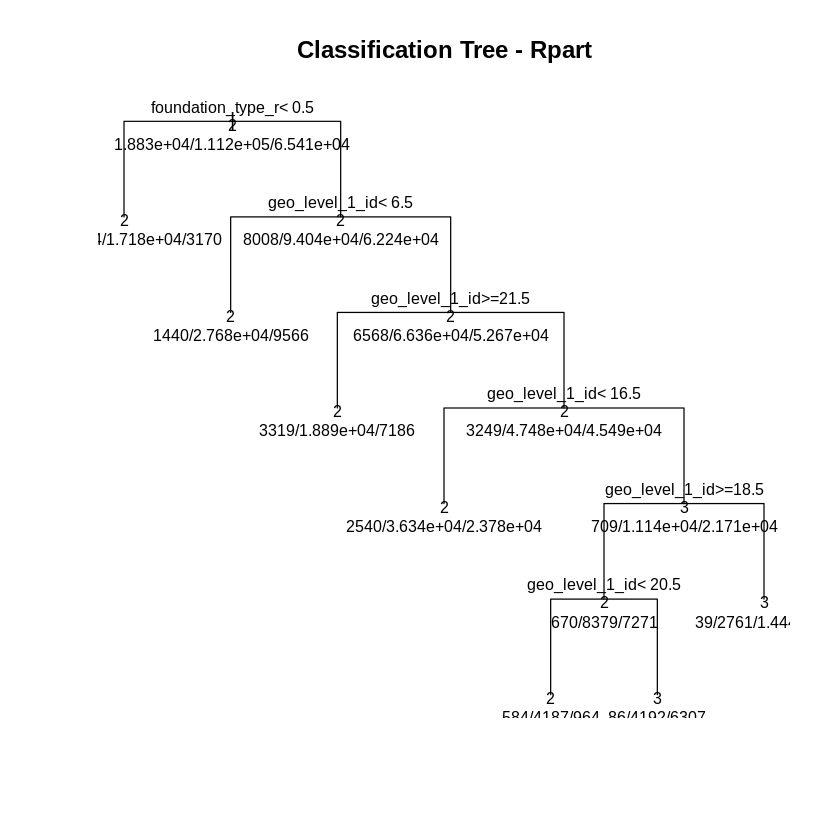

In [ ]:
# plot tree
plot(dt_model, uniform=TRUE,
   main="Classification Tree - Rpart")
text(dt_model, use.n=TRUE, all=TRUE, cex=.8)

### Random forest training

In [ ]:
DS_train <- cbind(X_train,damage_grade=as.factor(Y))
head(DS_train)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,area_percentage,age,foundation_type_r,count_floors_pre_eq,has_superstructure_mud_mortar_stone,count_families,ground_floor_type_v,damage_grade
,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<fct>
52922,8,463,10502,7,15,1,2,0,1,0,2
218087,25,868,362,8,25,1,2,1,1,0,2
236218,21,935,1956,6,0,1,2,1,1,0,3
215915,21,313,6134,3,5,1,2,1,0,0,2
172424,10,804,268,4,25,1,2,1,1,0,3
229706,20,385,10589,9,5,0,2,1,0,0,2


In [ ]:
# We only vary the number of trees, the package will automatically optimize the number of features

# --> Decomment what's follows to re-build the model 

# rf_rtree300_train=randomForest(damage_grade~ . , data = DS_train,importance=T,
#                         ntree=300,
#                         maxdepth = 45,
#                         minsplit = 3,
#                         minbucket = 30)
# rf_rtree300_train

In [ ]:
# saveRDS(rf_rtree300_train, file = "rf_rtree300_train.rds")
rf_rtree300_train <- readRDS(file = "rf_rtree300_train.rds")

### Deep neural network training

We chose a simple deep neural network. Having more layers complexifies the network, meaning it can learn more difficult patterns, but it also makes learning slower. The number of layers in a deep neural network depends on the complexity of the problem and we decided to go for for 4 denses layers. We alos decided to use the relu fonction as seen in pratical, because it has many good properties like simplicity, sparsity, non-linearity and efficiency. Like seen in pratical, we have chosen Adam optimizer for his efficiency.
To train our model, we have chosen 100 epoch because it allows a balance between time and performance.

--> Decomment the 3 following cells to re-build the model 

In [ ]:
# build_and_compile_model <- function(norm) {
#   model <- keras_model_sequential() %>%
#     norm() %>%
#     layer_dense(32, activation = 'relu') %>%
#     layer_dense(64, activation = 'relu') %>%
#     layer_dense(128,  activation = 'relu') %>%
#     layer_dense(1)
#   model %>% compile(
#     loss = 'mean_absolute_error',
#     optimizer = optimizer_adam(0.001)
#   )
#   model
# }

In [ ]:
# normalizer <- layer_normalization(axis = -1L)
# normalizer %>% adapt(as.matrix(X_train))
# dnn_model <- build_and_compile_model(normalizer)

In [ ]:
# history <- dnn_model %>% fit(
#   as.matrix(X_train),
#   as.matrix(Y),
#   validation_split = 0.2,
#   verbose = 0,
#   epochs = 100
# )

In [ ]:
# save_model_tf(dnn_model, 'dnn_model')
dnn_model <- load_model_tf('dnn_model')
dnn_model

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                  Output Shape               Param #    Trainable  
 normalization_2 (Normalizatio  (None, 10)                21         Y          
 n)                                                                             
 dense_7 (Dense)               (None, 32)                 352        Y          
 dense_6 (Dense)               (None, 64)                 2112       Y          
 dense_5 (Dense)               (None, 128)                8320       Y          
 dense_4 (Dense)               (None, 1)                  129        Y          
Total params: 10,934
Trainable params: 10,913
Non-trainable params: 21
________________________________________________________________________________

### Naive Bayes training

Naïve Bayes classifier is interesting because it is one of the simplest and most effective classification algorithms that helps to build rapid machine learning models that can make rapid predictions.

In [ ]:
#Train the Naive Bayes classifier

# --> Decomment the 3 following cells to re-build the model

# bayes <- NaiveBayes(X_train, as.factor(Y))

In [ ]:
# saveRDS(bayes, file = "bayes_train.rds")
bayes_train <- readRDS(file = "bayes_train.rds")

# Models evaluation  

## Compute the micro F1 score metric

In [ ]:
ConfusionMatrix <- function(y_pred, y_true) {
  Confusion_Mat <- table(y_true, y_pred)
  return(Confusion_Mat)
}
 
ConfusionDF <- function(y_pred, y_true) {
  Confusion_DF <- transform(as.data.frame(ConfusionMatrix(y_pred, y_true)),
                            y_true = as.character(y_true),
                            y_pred = as.character(y_pred),
                            Freq = as.integer(Freq))
  return(Confusion_DF)
}
 
Precision_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FP <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
  # it may happen that a label is never predicted (missing from y_pred) but exists in y_true
    # in this case ConfusionDF will not have these lines and thus the simplified code crashes
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]))
   
    # workaround:
    # i don't want to change ConfusionDF since i don't know if the current behaviour is a feature or a bug.
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
   
    tmp <- Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]
    FP[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Precision_micro <- sum(TP) / (sum(TP) + sum(FP))
  return(Precision_micro)
}
 
Recall_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FN <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # short version, comment out due to bug or feature of Confusion_DF
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]))
   
    # workaround:
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
 
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]
    FN[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Recall_micro <- sum(TP) / (sum(TP) + sum(FN))
  return(Recall_micro)
}
 
F1_Score_micro <- function(y_true, y_pred, labels = NULL) {
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred)) # possible problems if labels are missing from y_*
  Precision <- Precision_micro(y_true, y_pred, labels)
  Recall <- Recall_micro(y_true, y_pred, labels)
  F1_Score_micro <- 2 * (Precision * Recall) / (Precision + Recall)
  return(F1_Score_micro)
}

In [ ]:
# Get predicted values by decision tree
dt_predicted_values <- predict(dt_model, X_eval, type = "class")

In [ ]:
dt_F1_score_micro <-F1_Score_micro(Y_test, dt_predicted_values,labels=c(1,2,3))
cat("Desicion tree - F1 score micro score : ",dt_F1_score_micro,"\n")

Desicion tree - F1 score micro score :  0.6406461 


In [ ]:
# Get predicted values by random forest
rf_rtree300_eval_predictions <- predict(rf_rtree300_train,X_eval)
head(rf_rtree300_eval_predictions)

236218  83869  59648 148611  72319   3776 
     3      2      2      2      2      3 
Levels: 1 2 3

In [ ]:
rf_F1_score_micro <-F1_Score_micro(Y_test, rf_rtree300_eval_predictions,labels=c(1,2,3))
cat("Random forest - F1 score micro score : ",rf_F1_score_micro)

Random forest - F1 score micro score :  0.8127782

The random forest model seems very effective on validation data, which is that it probably over-trains.

In [ ]:
# Get predicted values by dnn 
test_results <- dnn_model %>% evaluate(
  as.matrix(X_eval),
  as.matrix(Y_test),
  verbose = 0
)
cat("Deep neural network - loss error : ",test_results)

Deep neural network - loss error :  0.33337

In [ ]:
dnn_predicted_test_labels <- predict(dnn_model, as.matrix(X_eval))
damage_grade <- round(dnn_predicted_test_labels)

In [ ]:
damage_grade_vec<-c(damage_grade)
head(damage_grade_vec)

[1] 3 2 2 2 2 2

In [ ]:
nt_F1_score_micro <-F1_Score_micro(Y_test, damage_grade_vec,labels=c(1,2,3))
cat("Deep neural network - F1 score micro score : ",nt_F1_score_micro)

Deep neural network - F1 score micro score :  0.6715469

In [ ]:
bayes_train_eval_predictions <- predict(bayes_train, as.matrix(X_eval))

Streaming output truncated to the last 5000 lines.
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 46475”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 46476”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 46477”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 46478”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 46479”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 46480”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 46481”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 46482”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 46483”
Warning message in FUN(X[[i]], 

The bayes predicitons generates warnigns that indicate that the model cannot classify these values. 
That may be so because values have a different pattern than others (outliers)

In [ ]:
bayes_train_eval_predictions <- bayes_train_eval_predictions$class
head(bayes_train_eval_predictions)

236218  83869  59648 148611  72319   3776 
     3      1      3      3      3      3 
Levels: 1 2 3

In [ ]:
by_F1_score_micro <-F1_Score_micro(Y_test, bayes_train_eval_predictions,labels=c(1,2,3))
cat("Naive bayes - F1 score micro score : ",by_F1_score_micro)

Naive bayes - F1 score micro score :  0.425001

# Models prediction & submission

In [ ]:
dt_predicted_test_labels <- predict(dt_model, X_test, type = "class")

In [ ]:
submission$damage_grade <- dt_predicted_test_labels
head(submission)

,building_id,damage_grade
,<int>,<fct>
1,300051,3
2,99355,2
3,890251,2
4,745817,2
5,421793,3
6,871976,2


In [ ]:
write.csv(x = submission, file = "dt_model_submission_format.csv",row.names = FALSE)

In [ ]:
rf_300_predicted_test_labels <- predict(rf_rtree300_train,X_test)

In [ ]:
submission$damage_grade <- rf_300_predicted_test_labels
head(submission)

,building_id,damage_grade
,<int>,<fct>
1,300051,3
2,99355,2
3,890251,2
4,745817,1
5,421793,3
6,871976,2


In [ ]:
write.csv(x = submission, file = "rf_model_submission_format.csv",row.names = FALSE)

In [ ]:
dnn_predicted_test_labels <- predict(dnn_model, as.matrix(X_test))
damage_grade <- round(dnn_predicted_test_labels)

In [ ]:
building_id <- submission[,'building_id']
dnn_test_predictions <- data.frame(building_id, damage_grade)

In [ ]:
write.csv(dnn_test_predictions, "dnn_model_submission_format.csv", row.names=FALSE)

In [ ]:
bayes_test_predictions <- predict(bayes_train, as.matrix(X_test))
bayes_test_predictions

Streaming output truncated to the last 5000 lines.
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 84369”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 84370”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 84371”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 84372”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 84373”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 84374”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 84375”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 84376”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 84377”
Warning message in FUN(X[[i]], 

1,2,3
8.558171e-04,0.1750202501,8.241239e-01
2.367812e-03,0.3225133665,6.751188e-01
5.286499e-03,0.2282052192,7.665083e-01
9.990021e-01,0.0009979487,4.037635e-16
1.437927e-03,0.1914570795,8.071050e-01
6.238270e-05,0.2259714008,7.739662e-01
9.607588e-01,0.0392411968,3.891206e-14
8.234800e-04,0.1842635262,8.149130e-01
5.188396e-04,0.1898974920,8.095837e-01
4.804057e-03,0.2580346337,7.371613e-01


In [ ]:
bayes_test_predictions<-bayes_test_predictions$class

In [ ]:
head(bayes_test_predictions)

[1] 3 3 3 1 3 3
Levels: 1 2 3

In [ ]:
submission$damage_grade <- bayes_test_predictions
head(submission)

,building_id,damage_grade
,<int>,<fct>
1,300051,3
2,99355,3
3,890251,3
4,745817,1
5,421793,3
6,871976,3


In [ ]:
write.csv(x = submission, file = "by_model_submission_format.csv",row.names = FALSE)

# Comparaison between models

* The model that gave the best score is the random forest model with a score of 0.7188.
* We have then the deep neural network with a score around 0.67.
* The decision tree comes with 0.6394
* Our worst model is the Naive Bayes that doesn't seem effective with 0.42.

NB : The score are the ones given by the platform

# Tuning model param

## Random forest

In [ ]:
rf_500 <- readRDS(file = "rf_model_3_rtree500.rds")

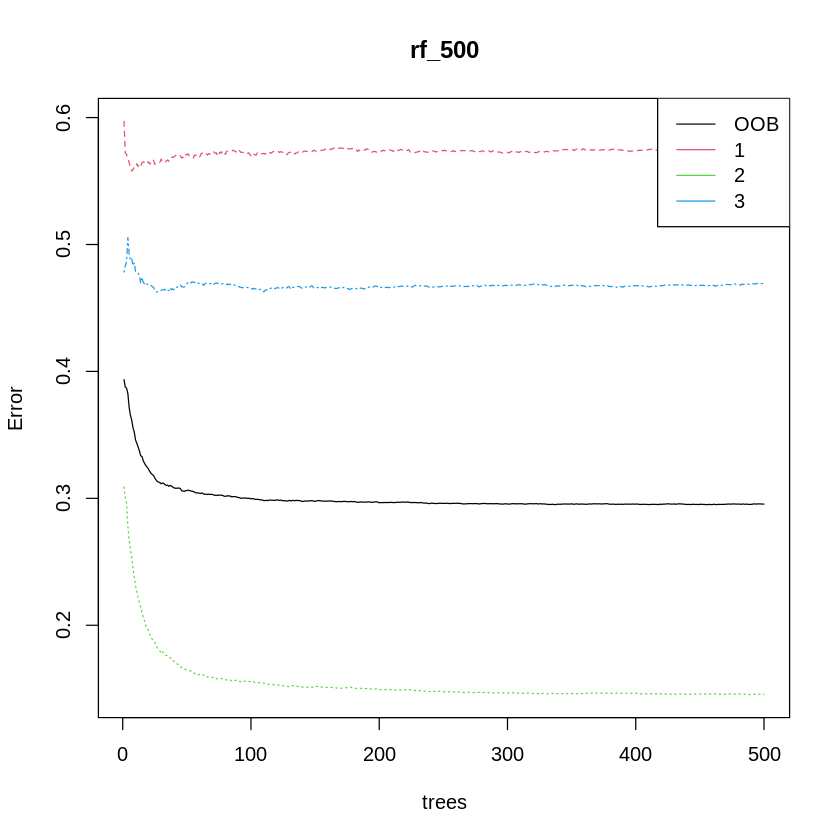

In [ ]:
plot(rf_500)
legend("topright", colnames(rf_500$err.rate), col = 1:ncol(rf_500$err.rate), lty = 1)

The black line in the chart represents the overall out-of-bag (OOB) error rate of the random forest model.

Colored lines representing the class-specific OOB error rates for each class in your data. 
These lines show how the OOB error rate for each class changes as more trees are added to the forest.

At the beginning, we have ran a first random forest model a number of trees of 500 because that recommended default values we find. This allows finding the optimal number that minimizes run time and ensures a low OOB error rate. We can see that from 300 we are not making much progress in terms of reducing the OOB error.

In [ ]:
# randomForest(damage_grade~ . , data = DS_train,importance=T,
#                         ntree=300,
#                         maxdepth = 45,
#                         minsplit = 3,
#                         minbucket = 30)

For other parameters, we have manually setted the value until we found the best trade-off that maximises the f1 score of the model.
* maxdepth : maximum depth of each tree in the forest
* minsplit : minimum number of observations that must be present in a node for a division to be attempted
* minbucket : minimum number of observations in any terminal node.

You should know that increasing the minsplit, minbucket can lead to underfitting, while decreasing them can lead to overfitting and for the maxdepth, this is the opposite.

## Feature selection based on conditional entropy

In [ ]:
X <- train_data[,setdiff(colnames(train_data),c("damage_grade"))]
Y <- train_data[,"damage_grade"]

In [ ]:
# Function to calculate entropy
entropy <- function(y, y_hat) {
  probs <- table(y, y_hat) / length(y)
  -sum(probs * log2(probs))
}

In [ ]:
# Initialize a vector to store the relevance scores
relevance <- numeric(ncol(X))

# Calculate relevance for each feature
for (i in 1:ncol(X)) {
  # Set aside the ith feature
  X_minus_i <- X[, -i]

  # Train a decision tree classifier
  tree_model <- rpart(as.factor(Y) ~ ., data = X_minus_i,method = "class",
               control = rpart.control(maxdepth = 30,minsplit = 3, minbucket = 30))

  # Predict the target variable using the modified feature set
  y_hat_minus_i <- predict(tree_model, newdata = X_minus_i, type = "class")

  # Calculate the entropy of y given X_minus_i
  H_y_X_minus_i <- entropy(Y, y_hat_minus_i)

  # Calculate the entropy of y given X
  H_y_X <- entropy(Y, predict(tree_model, type = "class"))

  # Compute the relevance of the ith feature
  relevance[i] <- H_y_X_minus_i - H_y_X
}

# Sort the features based on relevance in descending order
sorted_features <- names(X)[order(relevance, decreasing = TRUE)]

# Print the sorted feature rankings
cat("Feature Relevance Rankings:\n")
for (i in 1:length(sorted_features)) {
  cat(i, ": ", sorted_features[i], "\n")
}

Feature Relevance Rankings:
1 :  foundation_type_r 
2 :  has_superstructure_mud_mortar_stone 
3 :  geo_level_1_id 
4 :  geo_level_2_id 
5 :  geo_level_3_id 
6 :  count_floors_pre_eq 
7 :  age 
8 :  area_percentage 
9 :  land_surface_condition_n 
10 :  land_surface_condition_o 
11 :  land_surface_condition_t 
12 :  foundation_type_h 
13 :  foundation_type_i 
14 :  foundation_type_u 
15 :  foundation_type_w 
16 :  roof_type_n 
17 :  roof_type_q 
18 :  roof_type_x 
19 :  ground_floor_type_f 
20 :  ground_floor_type_m 
21 :  ground_floor_type_v 
22 :  ground_floor_type_x 
23 :  ground_floor_type_z 
24 :  other_floor_type_j 
25 :  other_floor_type_q 
26 :  other_floor_type_s 
27 :  other_floor_type_x 
28 :  position_j 
29 :  position_o 
30 :  position_s 
31 :  position_t 
32 :  plan_configuration_a 
33 :  plan_configuration_c 
34 :  plan_configuration_d 
35 :  plan_configuration_f 
36 :  plan_configuration_m 
37 :  plan_configuration_n 
38 :  plan_configuration_o 
39 :  plan_configuration_q

We can see that the 10 top features with this technique is the same as the ranking given by the random forest. Therefore, we can conclude that they are the best features to give to our model to train over.